Multimodal integration, by Angie Georgaras, Patrick Nolan, Harmeet Singh

Explanation of this notebook begins <a href='#start'>here</a>


In [94]:
#packages used throughout the notebook
import numpy as np
import pylab as py 
%matplotlib inline 
from IPython.display import Image, Audio
import math
import sklearn.decomposition 
from sklearn import decomposition
import PIL
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import pylab
from scipy import ndimage
import matplotlib
import wave
import sys
import random as random

# Black and White Vision Code

These functions are for collecting patches from black and white images, and then displaying them in order to show what they look like once PCA and ICA have been run.

In [95]:
def collectPatchesBW(numPatches, patchWidth, filePath):
    maxTries = numPatches * 50
    
    firstPatch = 0 # the first patch number accepted from an image
    firstTry = 0 # the first attempt to take a patch from the image
    patchCount = 0 # number of collected patches
    tryCount = 0 # number of attempted collected patches
    
    numPixels = patchWidth * patchWidth
    patchSample = np.zeros([patchWidth,patchWidth],'double')
    patch = np.zeros([numPixels,1],'double')
    imgPatches = np.zeros([numPixels,numPatches],'double')
    
                                                 
    # chooses the image that we're sampling from
    imgCount = 1  
    image = PIL.Image.open(filePath + str(imgCount) + '.jpg')
    imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread(filePath + str(imgCount) + '.jpg').shape
    image = image.convert('L')
    image = np.asarray(image, 'double').transpose()
    # normalizing the image
    image -= image.mean()
    image /= image.std()

    while patchCount < numPatches and tryCount < numPatches:
        tryCount += 1
        
        if (tryCount - firstTry) > maxTries/2 or (patchCount - firstPatch) > numPatches/2:
        # change the image sampled from to the next in the folder
            imgCount += 1
            image = PIL.Image.open(filePath + str(imgCount) + '.jpg')
            imageHeight, imageWidth, imageChannels = matplotlib.pyplot.imread(filePath + str(imgCount) + '.jpg').shape
            image = image.convert('L')
            image = np.asarray(image, 'double').transpose()
            # normalizing the image
            image -= image.mean()
            image /= image.std()
      
            firstPatch = patchCount
            firstTry = tryCount
        
        #starts patch collection in a random space
        px = np.random.randint(0,imageWidth - patchWidth)
        py = np.random.randint(0,imageHeight - patchWidth)

        patchSample = image[px:px+patchWidth,py:py+patchWidth].copy()
        patchStd = patchSample.std()

        if patchStd > 0.0: # > 0 to remove blank/uninteresting patches for speed
            # create the patch vector    
            patch = np.reshape(patchSample, numPixels)     
            patch = patch - np.mean(patch)         
            imgPatches[:,patchCount] = patch.copy()
            patchCount += 1
            
    return imgPatches

In [96]:
#this function displays BW image patches
def showPatchesBW(prePatches, showPatchNum = 16, display=True):
    patches = prePatches

    totalPatches = patches.shape[1]
    dataDim = patches.shape[0]
    patchWidth = int(np.round(np.sqrt(dataDim)))

    # extract show_patch_num patches
    displayPatch = np.zeros([dataDim, showPatchNum], float)
    for i in range(0,showPatchNum):
        patch_i = i * totalPatches // showPatchNum

        patch = patches[:,patch_i].copy()
        pmax  = patch.max()
        pmin = patch.min()
        # fix patch range from min to max to 0 to 1
        if pmax > pmin: 
            patch = (patch - pmin) / (pmax - pmin)
        displayPatch[:,i] = patch.copy()

    bw = 5    # border width
    pw = patchWidth

    patchesY = int(np.sqrt(showPatchNum))
    patchesX = int(np.ceil(float(showPatchNum) / patchesY))
    patchImg = displayPatch.max() * np.ones([(pw + bw) * patchesX - bw, patchesY * (pw + bw) - bw], float)
    for i in range(0,showPatchNum):
        y_i = i // patchesY
        x_i = i % patchesY

        reshaped = displayPatch[:,i].reshape((pw,pw))
        fullPatch = np.zeros([pw, pw], float)
        fullPatch[0:pw,:] = reshaped[:,:].copy()
        patchImg[x_i*(pw+bw):x_i*(pw+bw)+pw,y_i*(pw+bw):y_i*(pw+bw)+pw] = fullPatch

    if display:
        py.bone()
        py.imshow(patchImg.T, interpolation='nearest')
        py.axis('off')
    return


# Black and White Vision Code

These functions are for collecting patches from full color images, and then displaying them in order to show what they look like once PCA and ICA have been run.

In [97]:
# this function collects patches from the natural images
def collectPatchesColor(numPatches, patchWidth, filePath):

    maxTries = numPatches * 50
    imageWidth = 200

    firstPatch = 0  # the first patch number accepted from an image
    firstTry = 0  # the first attempt to take a patch from the image
    patchCount = 0  # number of collected patches
    tryCount = 0  # number of attempted collected patches
    
    numPixels = 3 * patchWidth * patchWidth
    patchSample = np.zeros([3, patchWidth, patchWidth], float)
    patch = np.zeros([numPixels], float)

    imgPatches = np.zeros([numPixels, numPatches], float)

  # this chooses the image we're sampling from, starting from the first image
    imgCount = 1
    image = PIL.Image.open(filePath + str(imgCount) + '.jpg')
    image = np.asarray(image, 'double').transpose()
    image = image[0:3, :, :]

  # normalizing the image
    image -= image.mean()
    image /= image.std()

  # collect the patches from images in file
    while patchCount < numPatches and tryCount < maxTries:
        tryCount += 1  # number of total patches attempted

        if tryCount - firstTry > maxTries / 2 or patchCount \
            - firstPatch > numPatches / 2:
            imgCount += 1  # this switches to the next image we're sampling from!
            image = PIL.Image.open(filePath + str(imgCount) + '.jpg')

            image = np.asarray(image, 'double').transpose()
            image = image[0:3, :, :]

            image -= image.mean()
            image /= image.std()

            firstPatch = patchCount
            firstTry = tryCount

        px = np.random.randint(0, imageWidth - patchWidth)
        py = np.random.randint(0, imageWidth - patchWidth)

        patchSample = image[:, px:px + patchWidth, py:py
                            + patchWidth].copy()

        patch_std = patchSample.std()

        if patch_std > 0.0:  # > 0 to remove blank/uninteresting patches for speed

      # create the patch vector

            patch = np.reshape(patchSample, numPixels)
            patch = patch - np.mean(patch)
            imgPatches[:, patchCount] = patch.copy()
            patchCount += 1
    return imgPatches


In [98]:
#this function displays the collected patches 
def showPatchesColor(prePatches, showPatchNum=16, display=True):

    patches = prePatches

    totalPatches = patches.shape[1]
    dataDim = patches.shape[0]
    patchWidth = int(np.round(np.sqrt(dataDim))) - 6

  # extract showPatchNum patches

    displayPatch = np.zeros([dataDim, showPatchNum], float)
    for i in range(0, showPatchNum):
        patch_i = i * totalPatches // showPatchNum

        patch = patches[:, patch_i].copy()
        pmax = patch.max()
        pmin = patch.min()

    # fix patch range from min to max to 0 to 1

        if pmax > pmin:
            patch = (patch - pmin) / (pmax - pmin)
        displayPatch[:, i] = patch.copy()

    bw = 5  # border width
    pw = patchWidth

    patchesY = int(np.sqrt(showPatchNum))
    patchesX = int(np.ceil(float(showPatchNum) / patchesY))
    patchImg = displayPatch.max() * np.ones([3, (pw + bw) * patchesX
            - bw, patchesY * (pw + bw) - bw], float)
    for i in range(0, showPatchNum):
        y_i = i // patchesY
        x_i = i % patchesY

    # reshape patch sizing

        reshaped = displayPatch[:, i].reshape((3, 8, 8))
        fullPatch = np.zeros([3, pw, pw], float)
        fullPatch[0:3, 0:8, 0:8] = reshaped[:, :, :].copy()
        patchImg[:, x_i * (pw + bw):x_i * (pw + bw) + pw, y_i * (pw
                 + bw):y_i * (pw + bw) + pw] = fullPatch

    if display:

    # displays the patches

        py.imshow(patchImg[:, :, :].T, interpolation='nearest')
        py.axis('off')
    return

# Audio Code

These functions are for collecting patches .wav sound files, and then displaying them in order to show what they look like once PCA and ICA have been run.

In [99]:
def collectPatchesAudio(file):
    spf = wave.open('audio/' + file + '.wav','r')
    # extract raw audio from .wav file

    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, 'Int16')
    fs = spf.getframerate()
    numSamples = len(signal)  
    width = 100

    ds = 3
    numPatches = 100000
    audioPatches = np.zeros((numPatches,width))
    for i in range(numPatches):
        x_start = np.random.randint(0,numSamples-ds*width-2)
        audioPatches[i,:] = signal[x_start:x_start+ds*width-1:ds]
   
    return(audioPatches)

In [100]:
def showPatchesAudio(patches):
    width = 100
    cnt = 0
    for cnt in range(20):
        plt.subplot(5, 5, cnt+1)
        frame = pylab.gca()
        frame.axes.get_xaxis().set_ticklabels([])
        frame.axes.get_yaxis().set_ticklabels([])
        plt.plot(range(width),patches[cnt,:])
    plt.show()


<a id='start'></a>
# Multimodal Efficient Coding Integration

A Jupyter Notebook demonstration of the efficient coding principle across various sensory modalities. 

Project by Angie Georgaras, Patrick Nolan, and Harmeet Singh

Code for modalities adapted from COMP 386 coursework and tutorials.


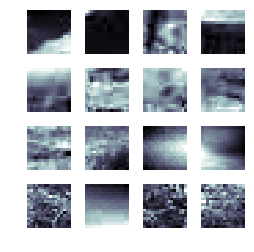

In [101]:
patchesBWNatural = collectPatchesBW(50000, 16, 'BW/natural/')
showPatchesBW(patchesBWNatural)

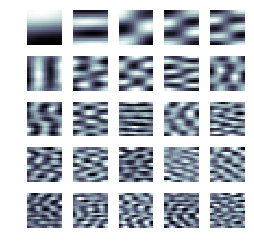

In [102]:
pcatemp = sklearn.decomposition.PCA(n_components=75)
pcafit = pcatemp.fit(np.transpose(patchesBWNatural))

pca_comp = pcafit.components_
showPatchesBW(np.transpose(pca_comp), 25)

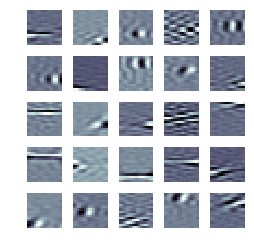

In [103]:
icatemp = sklearn.decomposition.FastICA(n_components=75)
icafit = icatemp.fit(np.transpose(patchesBWNatural))

ica_comp = icafit.components_
showPatchesBW(np.transpose(ica_comp), 25)

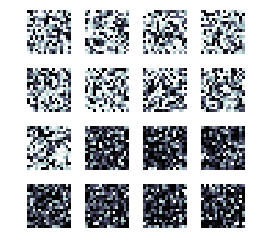

In [104]:
patchesBWUnnatural = collectPatchesBW(50000, 16, 'BW/unnatural/')
showPatchesBW(patchesBWUnnatural)

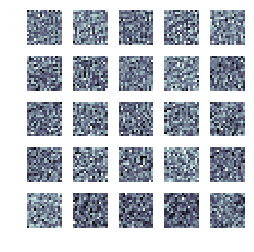

In [105]:
pcatemp = sklearn.decomposition.PCA(n_components=75)
pcafit = pcatemp.fit(np.transpose(patchesBWUnnatural))

pca_comp = pcafit.components_
showPatchesBW(np.transpose(pca_comp), 25)

In [ ]:
icatemp = sklearn.decomposition.FastICA(n_components=75)
icafit = icatemp.fit(np.transpose(patchesBWUnnatural))

ica_comp = icafit.components_
showPatchesBW(np.transpose(ica_comp), 25)

In [ ]:
patchesColorNatural = collectPatchesColor(10000, 8, 'color/natural/')
showPatchesColor(patchesColorNatural)

In [ ]:
# finding PCA components 
pcatemp = sklearn.decomposition.PCA(n_components=75)
pcafit = pcatemp.fit(np.transpose(patchesColorNatural))

pca_comp = pcafit.components_
showPatchesColor(np.transpose(pca_comp), 25)

In [ ]:
#finding ICA components
icatemp_c = sklearn.decomposition.FastICA(n_components=75)
icafit_c = icatemp_c.fit(np.transpose(patchesColorNatural))

ica_comp_c = icafit_c.components_
showPatchesColor(np.transpose(ica_comp_c), 25)

In [ ]:
patchesColorUnnatural = collectPatchesColor(10000, 8, 'color/unnatural/')
showPatchesColor(patchesColorUnnatural)

In [ ]:
pcatemp = sklearn.decomposition.PCA(n_components=75)
pcafit = pcatemp.fit(np.transpose(patchesColorUnnatural))

pca_comp = pcafit.components_
showPatchesColor(np.transpose(pca_comp), 25)

In [ ]:
icatemp_c = sklearn.decomposition.FastICA(n_components=75)
icafit_c = icatemp_c.fit(np.transpose(patchesColorUnnatural))

ica_comp_c = icafit_c.components_
showPatchesColor(np.transpose(ica_comp_c), 25)

In [ ]:
naturalSound = collectPatchesAudio('bill')
showPatchesAudio(naturalSound)

In [ ]:
# finding PCA components 
pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(naturalSound)

pca_comp = pcafit.components_
showPatchesAudio(pca_comp)

In [ ]:
# finding ICA components 
icatemp = sklearn.decomposition.FastICA(n_components=25)
icafit = icatemp.fit(naturalSound)

ica_comp = icafit.components_
showPatchesAudio(ica_comp)

In [ ]:
unnaturalSound = collectPatchesAudio('whitenoise')
showPatchesAudio(unnaturalSound)

In [ ]:
# finding PCA components 
pcatemp = sklearn.decomposition.PCA(n_components=25)
pcafit = pcatemp.fit(unnaturalSound)

pca_comp = pcafit.components_
showPatchesAudio(pca_comp)

In [ ]:
# finding ICA components 
icatemp = sklearn.decomposition.FastICA(n_components=25)
icafit = icatemp.fit(unnaturalSound)

ica_comp = icafit.components_
showPatchesAudio(ica_comp)